**VM: Deep Learning mit Python - Model from scratch**

*Group: Leo Giesen, Johannes Kauffmann*

Case Study: Create deep learning model to predict Land Use and Land Cover data drom satellite pictures.

# Imports and definitions

In [1]:
# Import of packages

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import calendar
import os
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv3D, MaxPooling3D, Dropout, BatchNormalization
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from imblearn.over_sampling import RandomOverSampler
import tensorflow_hub as hub
from keras.callbacks import EarlyStopping
from google.colab import drive

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
# mount Google drive to get the data

drive.mount('/content/gdrive')
root_path = 'gdrive/My Drive/Wirtschaftsinformatik/lulc_data'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
# Class names

class_names = {
    0: "No Data", 
    1: "Cultivated Land",
    2: "Forest",
    3: "Grassland",
    4: "Shrubland",
    5: "Water",
    6: "Wetlands",
    7: "Tundra",
    8: "Artificial Surface",
    9: "Bareland",
    10: "Snow and Ice"
}

In [4]:
# Channel names

channel_names = {
    1: "Red",
    2: "Green",
    3: "Blue",
    4: "NIR 1",
    5: "NIR 2",
    6: "NIR 3"
}

# Data Collection

**Loading data**

In [5]:
data = data = np.load(root_path + '/train.npz')
bands = data['bands'] # data: 10.000 patches, each for twelve months and with six channels. Resolution: 33x33 pixels
lulc = data['lulc'] # labels for central pixel of patches (Land Use and Land Cover)
print(bands.shape)
print(lulc.shape)

(10000, 12, 33, 33, 6)
(10000,)


**Examine data**

In [6]:
%%script false
# show number of instances per class

count_classes = []
for i in range(11): 
    val = np.count_nonzero(lulc == i)
    print("class "+str(i)+": "+str(val))
    count_classes.append(val)
#print(count_classes)

--> Realization: Class 2 is over-represented. Classes 6, 7 and 10 are not present in the data set at all.

In [7]:
%%script false
# Show some images

patch = 250 # patch number

print("Channels from patch no. " + str(patch))
print("Central pixel is labeled as " + class_names[lulc[patch]])

for month in range(12):
    plt.figure(figsize=(10, 10))
    for channel in range(6): #show all six channels
        ax = plt.subplot(3, 3, channel+1)
        image = bands[patch, month, :, :, channel]
        plt.imshow(image, cmap = plt.cm.binary)
        plt.title("Channel: " + channel_names[channel+1])
        plt.suptitle(calendar.month_name[month+1], size=16)
        plt.axis("off")

# Data Preparation

**Split data into train, validation and test data**

In [ ]:
X = bands
y = lulc

# split into train, test, vaildation sets
X_train_all, X_test, y_train_all, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_all, y_train_all, test_size=0.20)
print(X_train.shape)

# Create Tensorflow Dataset objects
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val))
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))

**Data augmentation**

In [9]:
# create data augmentation layer
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2)
])

AUTOTUNE = tf.data.AUTOTUNE

# define prepare function from tensorflow website
def prepare(ds, shuffle=False, augment=False):
  if shuffle:
    ds = ds.shuffle(10000)

  # Use data augmentation only on the training set
  if augment:
    ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
                num_parallel_calls=AUTOTUNE)

  # Use buffered prefecting on all datasets
  return ds.prefetch(buffer_size=AUTOTUNE)

train_ds = prepare(train_ds, shuffle=True, augment=True)
val_ds = prepare(val_ds, shuffle=True)
test_ds = prepare(test_ds, shuffle=True)
print(tf.data.experimental.cardinality(train_ds))
print(tf.data.experimental.cardinality(val_ds))
print(tf.data.experimental.cardinality(test_ds))

tf.Tensor(6400, shape=(), dtype=int64)
tf.Tensor(1600, shape=(), dtype=int64)
tf.Tensor(2000, shape=(), dtype=int64)


**Class weights** 

In [10]:
# Calculate class weights automatically
class_weights_array = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)

# Create dictionary for the class weights
class_weights_dict = {
    0: class_weights_array[0],
    1: class_weights_array[1],
    2: class_weights_array[2],
    3: class_weights_array[3],
    4: class_weights_array[4],
    5: class_weights_array[5],
    6: 0,
    7: 0,
    8: class_weights_array[6],
    9: class_weights_array[7],
    10: 0,
}

print(class_weights_dict)

{0: 0.9900990099009901, 1: 5.755395683453237, 2: 0.21390374331550802, 3: 1.0638297872340425, 4: 1.6736401673640167, 5: 20.512820512820515, 6: 0, 7: 0, 8: 5.970149253731344, 9: 2.5806451612903225, 10: 0}


**One-hot encoder**

In [11]:
# one-hot encoder for categorical_crossentropy loss to work in model
depth = 11
y_train = tf.one_hot(y_train, depth)
y_val = tf.one_hot(y_val, depth)
y_test = tf.one_hot(y_test, depth)

# Model choosing

**Build 3D CNN Model from scratch**

adapted by: https://towardsdatascience.com/step-by-step-implementation-3d-convolutional-neural-network-in-keras-12efbdd7b130

In [22]:
base_model = Sequential() # sequential model
base_model.add(Conv3D(32, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(12, 33,33,6)))
base_model.add(MaxPooling3D(pool_size=(2, 2, 2)))
base_model.add(BatchNormalization(center=True, scale=True))
#base_model.add(Dropout(0.5))
base_model.add(Conv3D(64, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform'))
base_model.add(MaxPooling3D(pool_size=(2, 2, 2)))
base_model.add(BatchNormalization(center=True, scale=True))
#base_model.add(Dropout(0.5))
base_model.add(Flatten())
base_model.add(Dense(256, activation='relu', kernel_initializer='he_uniform'))
base_model.add(Dense(256, activation='relu', kernel_initializer='he_uniform'))
base_model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
base_model.add(Dense(64, activation='relu', kernel_initializer='he_uniform'))
base_model.add(Dense(32, activation='relu', kernel_initializer='he_uniform'))
base_model.add(Dense(11, activation='softmax')) # number of outputs, in our case eleven different classes

In [23]:
base_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
#base_model.build((12, 33,33,6))
base_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_6 (Conv3D)            (None, 10, 31, 31, 32)    5216      
_________________________________________________________________
max_pooling3d_6 (MaxPooling3 (None, 5, 15, 15, 32)     0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 5, 15, 15, 32)     128       
_________________________________________________________________
conv3d_7 (Conv3D)            (None, 3, 13, 13, 64)     55360     
_________________________________________________________________
max_pooling3d_7 (MaxPooling3 (None, 1, 6, 6, 64)       0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 1, 6, 6, 64)       256       
_________________________________________________________________
flatten_3 (Flatten)          (None, 2304)             

# Model training

**Fitting Models**

In [24]:
#%%script false
# define callbacks
early_stopping_cb = EarlyStopping(monitor='val_accuracy', patience = 15)
checkpoint_cb = keras.callbacks.ModelCheckpoint("own_model.h5", save_best_only=True)

# fit the model
history = base_model.fit(train_ds, epochs=100, batch_size=32, 
                    validation_data=val_ds, callbacks=[checkpoint_cb, early_stopping_cb],
                    class_weight=class_weights_dict)

Epoch 1/100


ValueError: ignored

In [17]:
#%%script false
#base_model.save('gdrive/My Drive/Wirtschaftsinformatik/lulc_data/own_trainingData_500Epochs.h5') # save model in root directory
model = keras.models.load_model('own_model.h5')

In [ ]:
from google.colab import files
files.download("gdrive/My Drive/Wirtschaftsinformatik/lulc_data/own_trainingData_500Epochs.h5" ) 

# Evaluation

In [ ]:
#%%script false
# Calculate loss and accuracy
base_model.evaluate(X_test, y_test)
#63/63 [==============================] - 18s 288ms/step - loss: 0.8801 - accuracy: 0.6990

# Predicitions with test-set
y_pred = base_model.predict_classes(X_test)
plt.figure(figsize=(10, 10))
print("Predictions of Channel Red in January for nine test pictures:")
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(X_test[i, 0, :, :, 0], cmap = plt.cm.binary)
    plt.title("Predicition: " + str(y_pred[i]) + "; True label: " + str(y_test[i]))
    plt.axis("off")

In [ ]:
#%%script false
#Plot accuracy and loss of train and val set
plt.figure(figsize=(11,4))
plt.subplot(121)
plt.plot(history.history['accuracy'], color="green")
plt.plot(history.history['val_accuracy'], color="blue")
plt.title("Accuracy", fontsize=16)
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train', 'val'], loc='lower right')
plt.subplot(122)
plt.plot(history.history['loss'], color="red",)
plt.plot(history.history['val_loss'], color="orange")
plt.title("Loss", fontsize=16)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

# Make Predictions

**Testing on Public Test Set**

In [32]:
data_public_test = np.load(root_path + '/public_test.npz') # load public test set
bands_public_test = data_public_test['bands'] # extract only layer called 'bands'
print(bands_public_test.shape)

(12, 500, 500, 6)


In [ ]:
# Show all 12 monthly images of the public test set

for month in range(12):
    plt.figure(figsize=(10, 10))
    for channel in range(6): #show all six channels
        ax = plt.subplot(3, 3, channel+1)
        image = bands_public_test[month, :, :, channel]
        plt.imshow(image, cmap = plt.cm.binary)
        plt.title("Channel: " + channel_names[channel+1])
        plt.suptitle(calendar.month_name[month+1], size=16)
        plt.axis("off")

Output hidden; open in https://colab.research.google.com to view.

**Padding**

To be able to use the sliding window approach on the public test set.

In [33]:
bands_public_test_pad = np.zeros(shape=(12, 532, 532, 6)) # get empty array with correct shape

# perform padding for all images (months and channels)
for month in range(12):
    for channel in range(6):
        bands_public_test_pad[month, :, :,channel] = np.pad(bands_public_test[month, :, :,channel],
                                                            ((16,16),(16,16)), 'constant')
        
print(bands_public_test_pad.shape)

(12, 532, 532, 6)


Test padding by printing out the images of the public test set.

In [ ]:
for month in range(12):
    plt.figure(figsize=(10, 10))
    for channel in range(6): #show all six channels
        ax = plt.subplot(3, 3, channel+1)
        image = bands_public_test_pad[month, :, :, channel]
        plt.imshow(image)
        plt.title("Channel: " + channel_names[channel+1])
        plt.suptitle(calendar.month_name[month+1], size=16)
        plt.axis("off") 

In [34]:
# add one dimension to be able feeding our model

#bands_public_test = np.expand_dims(bands_public_test, 0)
bands_public_test_pad = np.expand_dims(bands_public_test_pad, 0)
bands_public_test_pad.shape

(1, 12, 532, 532, 6)

**Naive sliding window approach**

Iterate the model over the whole public test image with stepsize one.

In [39]:
x_coord_start = 15
x_coord_end = x_coord_start + 33

#print(current_cutout.shape) #(1, 12, 33, 33, 6)
y_pred_public_test = np.zeros(shape=(500, 500, 1))

for i in range(468):
    x_coord_end   += 1
    x_coord_start += 1
    y_coord_start = 15
    y_coord_end = y_coord_start + 33
    for j in range(468):
        y_coord_end   += 1
        y_coord_start += 1
        # pass every month & color channel 
        current_cutout = bands_public_test_pad[:, :, x_coord_start:x_coord_end, y_coord_start:y_coord_end, :]
        
        y_pred = base_model.predict_classes(current_cutout)
        y_pred_public_test[i][j] = y_pred[0]
        
        #Debugging
        #print("i: "+ str(i) + "  j: " + str(j)        + "  -  " +
        #      str(x_coord_start)+":"+str(x_coord_end) + "; "    +
        #      str(y_coord_start)+":"+str(y_coord_end) + "  -  " +
        #      str(int(y_pred_public_test[i][j])))
        #if(current_cutout.shape != (1, 12, 33, 33, 6)): 
            #print(str(current_cutout.shape) + "\n")

/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
1
6
1
1
6
1
6
1
6
6
6
6
1
1
1
6
6
6
6
6
1
6
6
6
6
1
1
1
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
1
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6


Exception ignored in: <function IteratorResourceDeleter.__del__ at 0x7f53bd55b710>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/iterator_ops.py", line 546, in __del__
    handle=self._handle, deleter=self._deleter)
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/ops/gen_dataset_ops.py", line 1264, in delete_iterator
    _ctx, "DeleteIterator", name, handle, deleter)
KeyboardInterrupt: 


6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6


KeyboardInterrupt: ignored

In [ ]:
#%%script false
with open("gdrive/My Drive/Wirtschaftsinformatik/lulc_data/y_pred_public_test.npy", "wb") as f:
    np.save(f, y_pred_public_test)

In [ ]:
#%%script false
with open("gdrive/My Drive/Wirtschaftsinformatik/lulc_data/y_pred_public_test.npy", "rb") as f:
    y_pred_public_test = np.load(f)

**Visualization of the result for the public test set**

Code adapted from https://stackoverflow.com/questions/37719304/python-imshow-set-certain-value-to-defined-color

In [ ]:
color_map = {
    0:  np.array([  0,   0,   0]), #0: "No Data"
    1:  np.array([240, 222,  60]), #1: "Cultivated Land"
    2:  np.array([ 47, 102,  31]), #2: "Forest"
    3:  np.array([162, 232, 142]), #3: "Grassland"
    4:  np.array([162, 176, 158]), #4: "Shrubland"
    5:  np.array([ 99, 189, 224]), #5: "Water"
    6:  np.array([ 44, 209, 154]), #6: "Wetlands"
    7:  np.array([230, 189,  41]), #7: "Tundra"
    8:  np.array([237,  82,  55]), #8: "Artificial Surface"
    9:  np.array([224, 180, 132]), #9: "Bareland"
    10: np.array([189, 189, 189]), #10: "Snow and Ice"
} 

# make a 3d numpy array that has a color channel dimension   
data_3d = np.ndarray(shape=(y_pred_public_test.shape[0], y_pred_public_test.shape[1],3), dtype=int)
for i in range(0, y_pred_public_test.shape[0]):
    for j in range(0, y_pred_public_test.shape[1]):
        data_3d[i][j] = color_map[y_pred_public_test[j,i,0]]
        print(data_3d[i][j])

# display the plot 
fig, ax = plt.subplots(1,1)
ax.imshow(data_3d)

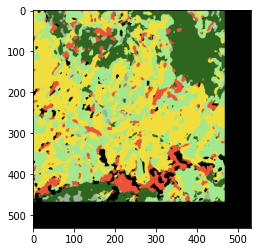

In [ ]:
# display the plot 
fig, ax = plt.subplots(1,1)
ax.imshow(data_3d)